# First, set up the training images

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import data

In [36]:
import numpy as np
import pandas as pd
path = "ML_training/training_data/"
X = np.load(path+'X.npy')
y = np.load(path+'y.npy')
file = np.load(path+'file.npy')

# set numpy seed for model
np.random.seed(0) # for reproducibility

In [37]:
# convert to grayscale (if you want)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

X = rgb2gray(X)
Xmlp = X
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Define CNN model

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [5]:
# Convolutional Neural Network https://machinelearningmastery.com/keras-functional-api-deep-learning/

# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential


input_shape = (X.shape[1], X.shape[2], X.shape[3])

nClasses = 2

def createModel():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.25))

#    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.25))

#    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.25))

#    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
 #   model.add(Conv2D(64, (1, 1), activation='relu'))
 #   model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.25))

    model.add(Flatten())
 #   model.add(Dense(1032, activation='relu', kernel_regularizer='l2'))
  #  model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='sigmoid'))
    
    return model

# plot_model(model, to_file='convolutional_neural_network.png')


# Define MLP model

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

# define and fit scaler
scaler = preprocessing.StandardScaler()


################## define and run model itself, after you've found good params ########
mlp = MLPClassifier(hidden_layer_sizes= (100, 50),
                    activation = 'relu',
                    solver = 'lbfgs',
                    alpha = 1e-5,
                    learning_rate = 'constant',
                    random_state = 0, max_iter=5000)

pipe = Pipeline(steps =[('scaler',scaler) , ('MLPClassifier', mlp)])

# Train CNN model

In [17]:
######### train test split ###############
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

######################
# Set training process params, class weights (get class weights from the train/test split, below)
batch_size = 64 # 67
epochs = 80 # 50

number_models= 5


###################
# construct metrics
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
###################


# full list of models and histories
models=list()
histories=list()
histories_all = list()



##################### ##################### ##################### 
# CNN MODEL
##################### ##################### ##################### 


X_cnn, X_val, y_cnn, y_val, file_cnn, file_val = train_test_split(X, y, file, stratify = y, test_size=0.15, random_state=0)


# compute class weights an assign to variable for model below
class_weights = class_weight.compute_class_weight('balanced', np.unique(y),y)
weight = {0: class_weights[0], 1: class_weights[1]}
print(weight)

# scale Xs and convert Ys to categorical
X_cnn, X_val = X_cnn/255, X_val/255
y_cnn, y_val = to_categorical(y_cnn), to_categorical(y_val)



# run ensemble CNN model for each kfold
for i in range(0,number_models):
  print(i)
  model = createModel()
  model.compile(optimizer='adamax', loss=keras.losses.BinaryCrossentropy(), metrics=metrics)
  history = model.fit(X_cnn, y_cnn,
                      batch_size=batch_size, 
                      epochs=epochs, verbose=1, class_weight = weight,
                      validation_data = (X_val, y_val),
                      # callbacks=[early_stopping], # this stops the training when the metric listed in model.compile has stopped improving
                      shuffle=False)
  
  # append to revolving models and histories list, in order to later append to full list of models and history
  models.append(model)
  histories.append(history.history)
  # append all histories for each model in each fold, to plot later
  histories_all.append(history.history)






{0: 0.5263862633900441, 1: 9.974626865671642}
0
Epoch 1/80
89/89 [==============================] - 3s 22ms/step - loss: 0.6011 - tp: 2379.9111 - fp: 699.1111 - tn: 2211.8222 - fn: 531.0222 - accuracy: 0.7851 - precision: 0.7640 - recall: 0.8376 - auc: 0.8587 - val_loss: 0.6428 - val_tp: 598.0000 - val_fp: 416.0000 - val_tn: 587.0000 - val_fn: 405.0000 - val_accuracy: 0.5907 - val_precision: 0.5897 - val_recall: 0.5962 - val_auc: 0.7371
Epoch 2/80
89/89 [==============================] - 1s 13ms/step - loss: 0.4506 - tp: 2054.0667 - fp: 868.9222 - tn: 2042.0111 - fn: 856.8667 - accuracy: 0.7124 - precision: 0.7115 - recall: 0.7145 - auc: 0.8331 - val_loss: 0.5830 - val_tp: 614.0000 - val_fp: 400.0000 - val_tn: 603.0000 - val_fn: 389.0000 - val_accuracy: 0.6067 - val_precision: 0.6055 - val_recall: 0.6122 - val_auc: 0.7543
Epoch 3/80
89/89 [==============================] - 1s 13ms/step - loss: 0.4506 - tp: 2033.4889 - fp: 890.9667 - tn: 2019.9667 - fn: 877.4444 - accuracy: 0.6936 - pre

NameError: ignored

In [19]:
# save histories and models
import pickle

for model in range(0,5):
  path = 'ML_models/ensemblemodel' + '-' + str(model)
  models[model].save(path)

with open("ML_models/ensemblemodel_histories.dat", "wb") as f:
  pickle.dump(histories, f)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/COLAB/train_using_all_data/ensemblemodel_-0/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COLAB/train_using_all_data/ensemblemodel_-1/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COLAB/train_using_all_data/ensemblemodel_-2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COLAB/train_using_all_data/ensemblemodel_-3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COLAB/train_using_all_data/ensemblemodel_-4/assets


# MLP model

In [38]:

####################################
###### scale and classify! ######
####################################

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# define and fit scaler
scaler = preprocessing.StandardScaler()


################## define and run model itself, after you've found good params ########
mlp = MLPClassifier(hidden_layer_sizes= (100, 50),
                    activation = 'relu',
                    solver = 'lbfgs',
                    alpha = 1e-5,
                    learning_rate = 'constant',
                    random_state = 0, max_iter=5000)

pipe = Pipeline(steps =[('scaler',scaler) , ('MLPClassifier', mlp)])



pipes = list()

# reshape X array to 2-dimensions
nsamples, nx, ny = Xmlp.shape
Xmlp = Xmlp.reshape((nsamples, nx*ny))

# resample training data
over = SMOTE(sampling_strategy = .1)
under = RandomUnderSampler(sampling_strategy=1)
Xmlp, y = over.fit_resample(Xmlp, y)
Xmlp, y = under.fit_resample(Xmlp, y)

# run it

for i in range(0,5):
    
    pipe.fit(Xmlp, y)
    
    pipes.append(pipe)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [46]:
# save the models
import pickle as pkl

path  = '/ML_models/MLP/'
file = path+'mlp_models.pkl'
with open(file, 'wb') as f:
    pkl.dump(pipes, f)

# Plot accuracy and loss for full model

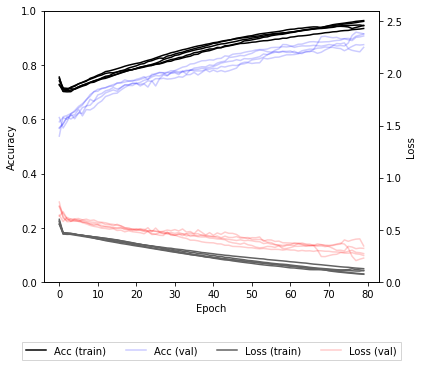

In [53]:
import matplotlib.pyplot as plt
hists = histories_all

# fig size
mpl.rcParams['figure.figsize'] = (6, 5)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()

# make a plot
ax.set_ylim(0,1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy",color="black")

ax2=ax.twinx()
ax2.set_ylim(0,2.6)
ax2.set_ylabel("Loss",color="black")

for h in range(0,5):
  a, = ax.plot(hists[h]['accuracy'], color="black")
  l, = ax2.plot(hists[h]['loss'], color="#626262")

for h in range(0,5):
  va, = ax.plot(hists[h]['val_accuracy'], color="blue", alpha=0.2)
  vl, = ax2.plot(hists[h]['val_loss'], color="red", alpha=0.2)

plt.legend(handles = [a, va, l, vl], labels = ['Acc (train)', 'Acc (val)', 'Loss (train)', 'Loss (val)'], loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)


# save the plot as a file
fig.savefig('/content/drive/MyDrive/COLAB/accloss_all.pdf',
            format='pdf',
            bbox_inches='tight')